# Import Module


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from pycocotools.coco import COCO
from collections import Counter

In [2]:
root = 'dataset'
train_json = "dataset/train.json"

# Json File Load

In [3]:
json_file = None
with open(train_json, 'r') as f:
    json_file = json.load(f)

In [4]:
annotations = json_file["annotations"]
images = json_file["images"]
categories = json_file["categories"]

# Dataset

## 객체 종류
객체의 class는 10가지로 분류 (0 ~ 9)

In [5]:
categories = pd.DataFrame(categories)
categories

,id,name,supercategory
0,0,General trash,General trash
1,1,Paper,Paper
2,2,Paper pack,Paper pack
3,3,Metal,Metal
4,4,Glass,Glass
5,5,Plastic,Plastic
6,6,Styrofoam,Styrofoam
7,7,Plastic bag,Plastic bag
8,8,Battery,Battery
9,9,Clothing,Clothing


## Data Sample

## 클래스별 데이터 개수

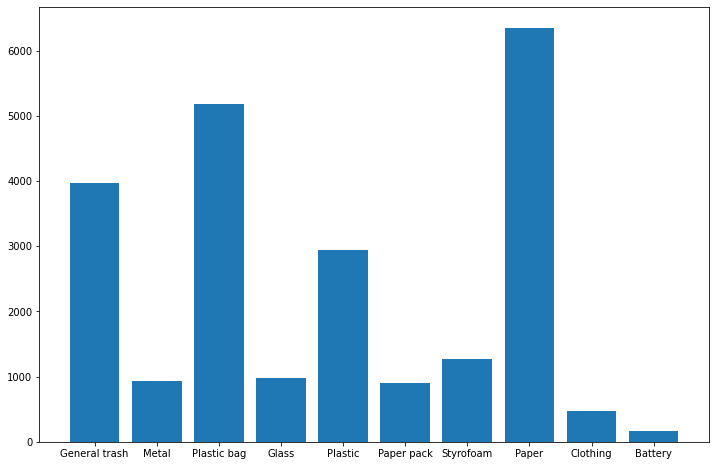

In [6]:
categories = json_file["categories"]

def id_to_name(c_id):
    return categories[c_id]['name']

ids = [id_to_name(ann['category_id']) for ann in annotations]
counts = Counter(ids)

plt.figure(figsize=(12, 8))
plt.bar(counts.keys(), counts.values())
plt.show()

- 객체의 종류(Class)별로 imbalance 가 있어 overfiting의 가능성이 있음
- imbalance 문제를 해결하기 위해 Data augmentation을 적용해 볼 수 있고 cls head의 loss를 focal loss나 labelsmoothing loss를 적용해 볼 수 있음
- 데이터셋 자체에서 oversampling, undersampling 적용

## 이미지 한장에서 등장하는 객체 개수

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


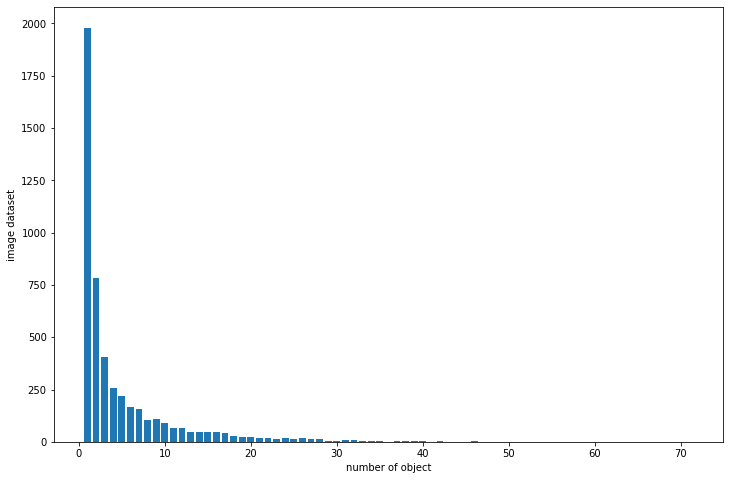

In [7]:
train_coco = COCO(train_json)

def id_to_objnum(ann):
    return len(train_coco.getAnnIds(imgIds = ann['id']))

obj_num = [id_to_objnum(ann) for ann in images]
counts = Counter(obj_num)

plt.figure(figsize=(12, 8))
plt.bar(counts.keys(), counts.values(), align='center')
plt.xlabel('number of object')
plt.ylabel('image dataset')
plt.show()

In [8]:
obj_table = pd.DataFrame(list(counts.items()), columns=['obj num', 'dataset'])
obj_table = obj_table.sort_values(by='dataset', ascending=False)
obj_table

,obj num,dataset
0,1,1980
2,2,783
6,3,405
11,4,259
8,5,218
3,6,166
5,7,157
19,9,107
1,8,102
10,10,88


## BBox 사이즈

In [9]:
boxes = []

def bbox_to_wh(bbox):
    return(round(bbox[2]), round(bbox[3]))

for ann in images:
    img_id = ann['id']
    ann_ids = train_coco.getAnnIds(imgIds=img_id)
    boxes += [bbox_to_wh(train_coco.loadAnns(ann)[0]['bbox']) for ann in ann_ids]
counts = Counter(boxes)
counts

Counter({(548, 470): 1,
         (58, 181): 1,
         (145, 182): 1,
         (274, 252): 1,
         (234, 103): 1,
         (778, 242): 1,
         (216, 180): 2,
         (139, 53): 1,
         (73, 94): 1,
         (632, 513): 1,
         (234, 255): 1,
         (188, 428): 1,
         (165, 89): 2,
         (164, 201): 1,
         (130, 252): 1,
         (212, 256): 1,
         (278, 208): 1,
         (101, 45): 2,
         (317, 130): 1,
         (183, 66): 1,
         (167, 62): 1,
         (43, 18): 2,
         (45, 86): 1,
         (129, 97): 1,
         (83, 99): 1,
         (442, 164): 1,
         (134, 132): 1,
         (164, 166): 1,
         (209, 354): 1,
         (75, 106): 2,
         (961, 239): 1,
         (125, 38): 1,
         (173, 96): 2,
         (334, 430): 2,
         (605, 468): 1,
         (544, 317): 1,
         (70, 44): 2,
         (346, 321): 1,
         (52, 71): 2,
         (130, 60): 1,
         (399, 559): 1,
         (752, 477): 1,
         (709, 

- 데이터셋 이미지 한장에서 등장하는 객체는 대부분 1장
- 가장 많은 객체가 존재하는 이미지는 71개의 객체를 갖고 있음
- 너무 많은 객체를 포함하고 있는 이미지는 노이즈로 설정하여 학습데이터에서 제외하는것을 고려할 수 있음

## 클래스별 bbox 사이즈 평균

In [10]:
c_box_dict = dict()

for ann in annotations:
    
    if c_box_dict.get(ann['category_id']):
        c_box_dict[ann['category_id']].append(bbox_to_wh(ann['bbox']))
    else:
        c_box_dict[ann['category_id']] = [bbox_to_wh(ann['bbox'])]

c_boxsize_dict = dict()

for category in c_box_dict:
    # print(category)
    width = [box[0] for box in c_box_dict[category]]
    height = [box[1] for box in c_box_dict[category]]
    
    c_boxsize_dict[category] = (round(sum(width)/len(width), 1), round(sum(height)/len(height), 1))

In [11]:
c_boxsize_dict

{0: (226.2, 215.5),
 3: (251.0, 257.2),
 7: (275.4, 301.2),
 4: (206.1, 271.9),
 5: (239.4, 230.7),
 2: (244.9, 220.1),
 6: (299.2, 252.3),
 1: (263.9, 236.7),
 9: (394.7, 391.7),
 8: (228.9, 215.0)}

- 클래스별 평균적인 크기를 계산했을 때 clothing(9)과 styrofoam(6)이 box 크기가 큼

## Bbox 비율

In [12]:
ratio = {}
round_up = 1 # 0: 소수점에서 반올림 1: 소수 첫번째 자리까지 반올림 2: ,...
for ann in annotations:
    bbox = ann["bbox"]
    width = bbox[2]
    height = bbox[3]
    #print("ratio:", width, ":", height, "\t\t", round(width/height, 1))
    try:
        ratio[f"{round(width/height, round_up)}"] += 1
    except:
        ratio[f"{round(width/height, round_up)}"] = 1

print(len(annotations), "-->", len(ratio))

23144 --> 137


<BarContainer object of 50 artists>

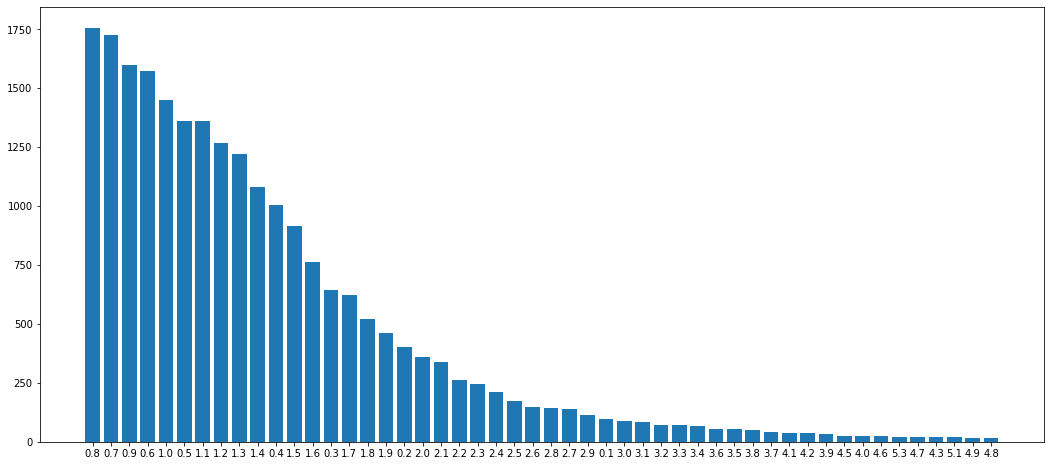

In [15]:
sorted_ratio = sorted(ratio.items(), key=lambda x: x[1], reverse = True)

top = 50
plt.figure(figsize=(18, 8))
x, y = zip(*sorted_ratio)
plt.bar(x[:top], y[:top])